In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]


%load_ext autoreload
%autoreload 2


In [2]:
def rho_comp(theta, k_func, Xb, yb, Xc, yc):
    Kb = k_func(theta, Xb[:, None], Xb) # make_kernel_matrix(k_func, Xb, Xb)
    Kb += 1e-12 * np.eye(len(Kb)) # TODO: REVIEW. just to be sure with Cholesky

    Kc = k_func(theta, Xc[:, None], Xc) # make_kernel_matrix(k_func, Xc, Xc)
    Kc += 1e-12 * np.eye(len(Kc)) # TODO: REVIEW. just to be sure with Cholesky
    
    return 1 - (yb @ np.linalg.solve(Kb, yb))/(yc @ np.linalg.solve(Kc, yc))


In [3]:
def logistic_map(r):
    def helper(x):
        return r * x * (1 - x)
    return helper

In [4]:
def gen_traj(curr_map, x0, N):

    x_curr = x0
    res = []
    for _ in range(N):
        res.append(x_curr)
        x_curr = curr_map(x_curr)

    res.append(x_curr)
    
    return res

In [5]:
def logistic_kernel(theta, x, y):
    a0, s1, s2, s3 = theta
    xy_norm_squared = ((x - y)**2).sum(-1)
    return a0 * np.exp(-s1 * np.sin(np.pi * s2 * np.sqrt(xy_norm_squared))**2) * np.exp(-xy_norm_squared/(s3**2)) 
        

def get_predict_func(theta, k_func, X, Y):
    K_XX = k_func(theta, X[:, None], X) #+ 1e-12 * np.eye(len(X)) # make_kernel_matrix(k_func, X, X)
    K_XXinv_Y = np.linalg.solve(K_XX, Y)
    
    
    def helper(x):
        K_Xx = np.empty(len(X))
        for i in range(len(X)):
            K_Xx[i] = k_func(theta, x, X[i])
        return K_Xx.T @ K_XXinv_Y
        
    return helper

In [6]:
# Get the Dataset 
r = 4
curr_map = logistic_map(r)
x0 = 0.1
N = 200
traj_train = np.array(gen_traj(curr_map, x0, N))


X_train = traj_train[:-1]
Y_train = traj_train[1:]


In [7]:
# set up rho relative loss

N_sub = 100

b_idxs = np.random.choice(len(X_train), N_sub)
c_idxs = None # np.random.choice(len(X), N_sub)
Xb = X_train[b_idxs].reshape(-1, 1)
yb = Y_train[b_idxs]

if c_idxs is None:
    Xc = X_train.reshape(-1, 1)
    yc = Y_train
else:
    Xc = X_train[c_idxs].reshape(-1, 1)
    yc = Y_train[c_idxs]

Xb = np.array(Xb)
yb = np.array(yb)

Xc = np.array(Xc)
yc = np.array(yc)

In [8]:
theta_paper = np.array([0.95, 0.98, 1.20, 0.62])

In [9]:
theta_base = np.array([1., 1., 1., 1.])
theta_learned = np.array([1.12231798, 0.46099936, 1.52390345, 1.24118606])

In [12]:
# Get rho relative loss
print("Paper rho relative loss", rho_comp(theta_paper, logistic_kernel, Xb, yb, Xc, yc))
print("Base rho relative loss", rho_comp(theta_base, logistic_kernel, Xb, yb, Xc, yc))
print("Learned rho relative loss", rho_comp(theta_learned, logistic_kernel, Xb, yb, Xc, yc))

Paper rho relative loss 0.037843739151178335
Base rho relative loss 0.038413358180972135
Learned rho relative loss 0.015565871527894348


In [13]:
# Get learned maps
base_map = get_predict_func(theta_base, logistic_kernel, X_train.reshape(-1, 1), Y_train)
paper_map = get_predict_func(theta_paper, logistic_kernel, X_train.reshape(-1, 1), Y_train)
learned_map = get_predict_func(theta_learned, logistic_kernel, X_train.reshape(-1, 1), Y_train)

In [25]:
# Generate predictions
x0 = 0.4
N = 50
traj_test = np.array(gen_traj(curr_map, x0, N))


base_res = np.array([base_map(x) for x in traj_test])
print("Base Completed")
paper_res = np.array([paper_map(x) for x in traj_test])
print("Paper Completed")
learned_res = np.array([learned_map(x) for x in traj_test])
print("Learned Completed")

Base Completed
Paper Completed
Learned Completed


In [26]:
print("Paper loss", np.linalg.norm(traj_test[1:] - paper_res[:-1]))
print("Base loss", np.linalg.norm(traj_test[1:] - base_res[:-1]))
print("Learned loss", np.linalg.norm(traj_test[1:] - learned_res[:-1]))

Paper loss 3.2267295926863677e-07
Base loss 1.3477029186013835e-07
Learned loss 8.909907515941305e-08


Text(0.5, 0, 'k')

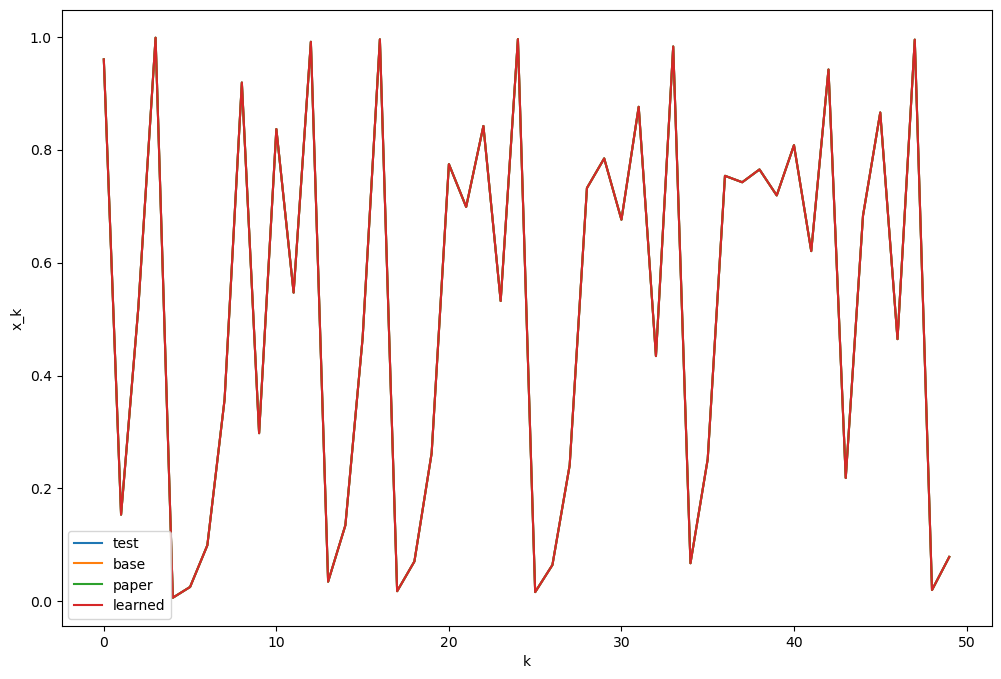

In [27]:
plt.plot(traj_test[1:], label="test")
plt.plot(base_res[:-1], label="base")
plt.plot(paper_res[:-1], label="paper")
plt.plot(learned_res[:-1], label="learned")


plt.legend()
plt.ylabel("x_k")
plt.xlabel("k")

In [32]:
# autoregressive

x0 = 0.1
learned_res = gen_traj(learned_map, x0, N)
paper_res = gen_traj(paper_map, x0, N)
base_res = gen_traj(base_map, x0, N)
traj_true = gen_traj(curr_map, x0, N)

Text(0.5, 0, 'k')

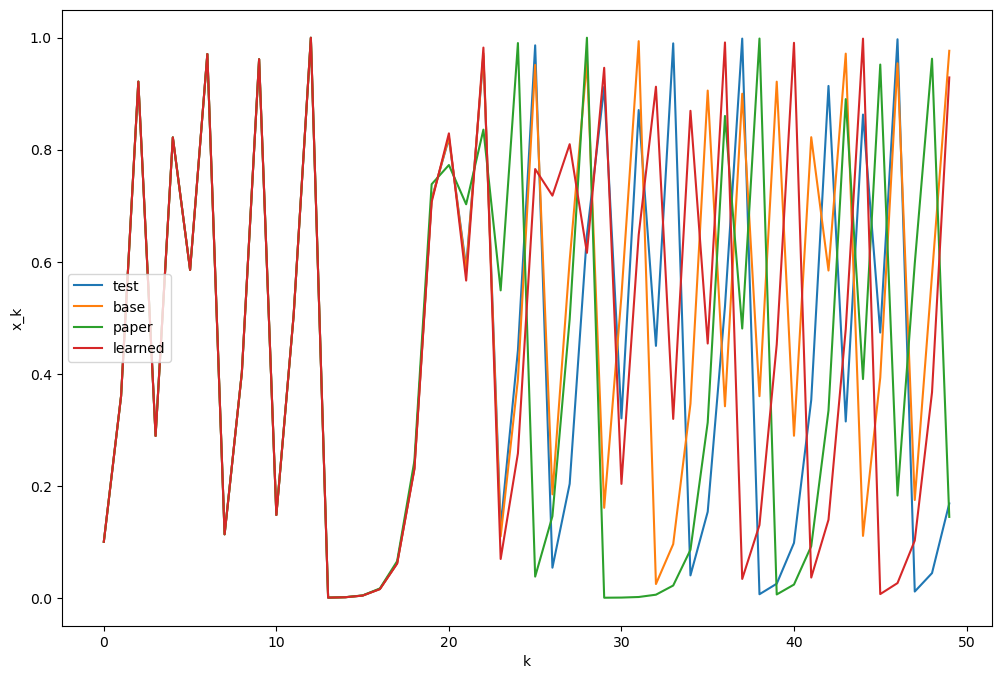

In [33]:
plt.plot(traj_true[:-1], label="test")
plt.plot(base_res[:-1], label="base")
plt.plot(paper_res[:-1], label="paper")
plt.plot(learned_res[:-1], label="learned")


plt.legend()
plt.ylabel("x_k")
plt.xlabel("k")

In [120]:
curr_map(0.1)

0.36000000000000004

In [ ]:
# distribution of initial conditions to get error bars and average performance. 